# IMPORTE DE LIBRERIAS

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import argparse
from matplotlib import pyplot as plt
import matplotlib.image as img
from sklearn.preprocessing import normalize                           
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from skimage import data, segmentation, color
from skimage.future import graph
from sklearn import cluster
from sklearn.cluster import MeanShift, estimate_bandwidth
from numpy import linspace
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import seaborn as sns
from cv2 import MORPH_ELLIPSE
from sklearn.cluster import spectral_clustering
from sklearn.cluster import AgglomerativeClustering
from kneed import KneeLocator
import seaborn
from skimage.feature import graycomatrix, graycoprops
from rotating_calipers import min_max_feret
import skimage.morphology

# FUNCIONES

# Feret

In [2]:
def get_min_max_feret_from_mask(mask_im):
    
    eroded = skimage.morphology.erosion(mask_im)
    outline = mask_im ^ eroded
    boundary_points = np.argwhere(outline > 0)
    # convert numpy array to a list of (x,y) tuple points
    boundary_point_list = list(map(list, list(boundary_points)))
    return min_max_feret(boundary_point_list)

# Slic

Crea superpixeles sobre la imagen de entrada a color

In [3]:
def superSlic(img):
    labels1 = segmentation.slic(img,compactness=30, n_segments=185, start_label=1)
    # super EN RGB
    out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)
    out1  = cv2.cvtColor(out1,cv2.COLOR_RGB2GRAY)
    #out1 = out1[:,:,0]
    return out1

# K mean

Técnica de Aprendizaje Automático no supervisado que agrupa los pixeles de acuerdo  a la similaridad en su intensidad

In [4]:
def kmean(pixelsValues,grupos,filtro):
    #algoritmo = KMeans(grupos,init='k-means++',max_iter=300,n_init=10)
    algoritmo = KMeans(n_clusters=grupos,init = 'k-means++',random_state=0);
    algoritmo.fit(pixelsValues);
    #algoritmo.fit_predict(pixelsValues)
    centroide, etiqueta = algoritmo.cluster_centers_,algoritmo.labels_
    centroide  = np.uint8(centroide)
    segmentacion_data  = centroide[etiqueta.flatten()]
    segmentacionImagen  = segmentacion_data.reshape(filtro.shape)
    return segmentacionImagen

# MeanShift

Algoritmo de aprendizaje no supervisado que etiqueta cada pixel de acuerdo a sus caracteríticas de intensidad, y lo agrupa en un Cluster

In [4]:
def shift2(pixelsValues,filtro):
    bandwidth = estimate_bandwidth(pixelsValues, quantile=0.2,n_samples=1000)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(pixelsValues)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    cluster_centers = np.uint8(cluster_centers)
    segmentacionImagen = cluster_centers[labels.flatten()]
    segmentacionImagen = segmentacionImagen.reshape(filtro.shape)
    return segmentacionImagen

# Seleccionador de Núcleos

A partir de una imagen que contenga más de un posible nucleo, selecciona aquel que se encuentre mas cercano al centro de la imagen

In [5]:
def selContorno(contours,thresh):
    if contours == None:
        return None
    else:
        
        listaDifx = []
        listaDify = []
        dif = pd.DataFrame()

        for k in range(len(contours)):
 
            cnt = contours[k]
            

            M = cv2.moments(cnt)
            cx = int(M['m10']/M['m00'])
            dimension = thresh.shape
            refx = dimension[1]/2
            # análisis x
            if cx <= refx:
                difx= refx-cx
            else:
                difx= cx - refx
            listaDifx.append(difx)

        for k in range(len(contours)):
            cnt = contours[k]
            M = cv2.moments(cnt)
            cy = int(M['m01']/M['m00'])
            dimension = thresh.shape
            refy = dimension[0]/2
            # análisis y
            if cy <= refy:
                dify= refy-cy
            else:
                dify= cy - refy
            listaDify.append(dify)
        dif['x'] = listaDifx
        dif['y'] = listaDify
        dif['total'] = dif['x'] + dif['y']
        dif.reset_index(inplace = True, drop  = True)
        cont = dif['total'].idxmin()
        #print(dif)
        #print('contorno',cont)
        return [cont,cx,cy]

# Seleccionador de Regiones

Si al momento de la segmentación queda el núcleo con un hueco dentro de él, esta función permite rellenar dicho núcleo

In [6]:
def selRegion(label,area):
    color = label.copy()
    color = color.reshape(-1,1)
    color = np.unique(color)
    color = np.sort(color,axis=None)
    color = np.uint8(color)
    for el in range(1,len(color)):
        region = label.copy()
        region[region != color[el]] = 0
        region[region == color[el]] = 255
        region = np.uint8(region)
        if np.sum(region == 255) != 0:
            contoursReg, hierarchyReg = cv2.findContours(region, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            contornoReg,rx,ry = selContorno(contoursReg,region)
            areaReg = cv2.contourArea(contoursReg[contornoReg])
            numReg = el
            numCont = len(contoursReg)
            #print(areaReg,area)
            if areaReg == area :
                numReg = el
                numCont = len(contoursReg)
                #print(numReg,numCont)
                #numCont = len(contoursReg)
                break

    nucleoReg = label.copy()
    nucleoReg = np.uint8(nucleoReg)
    nucleoReg[nucleoReg != numReg] = 0
    nucleoReg[nucleoReg == numReg] = 255

    if numCont >=2:
        # nucleoRegFill = nucleoReg.copy()
        # h,w = nucleoReg.shape[:2]
        # mask = np.zeros((h+2,w+2),np.uint8)
        # #floofill
        # cv2.floodFill(nucleoRegFill,mask,(0,0),255)
        # #invertir
        # nucleoRegFillInv = cv2.bitwise_not(nucleoRegFill)
        # #combinar ambas imagenes
        # nucleoReg = nucleoReg | nucleoRegFillInv



        # Invertir la imagen (los agujeros se convierten en objetos)
        img_inverted = cv2.bitwise_not(nucleoReg)
        # Etiquetar los componentes conectados en la imagen
        n_components, labels, stats, centroids = cv2.connectedComponentsWithStats(img_inverted)
        # Encuentra el componente más grande (background)
        max_label, max_area = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, n_components)], key=lambda x: x[1])
        # Cree una imagen en blanco con el tamaño de la imagen original
        filled_img = np.zeros(img_inverted.shape, dtype=np.uint8)
        # Rellena el componente más grande en la imagen en blanco
        filled_img[labels == max_label] = 255
        # Invertir la imagen de nuevo (los objetos se convierten en agujeros llenos)
        nucleoReg = cv2.bitwise_not(filled_img)
        
        

    return nucleoReg

# Matriz de Confusión

Cada imagen Segmentada, se la Compara con la imagen de referencia y se determinan las valores de Verdadero Negativo, Verdadero Positivo, Falso Negativo y Falso Positivo, con el fin de evaluar la imagen Segmentada

In [7]:
def matrizConfusion (img_propuesta,img_referencia):
    #variables locales: FP falso positivo,  FN falso negativo, VP verdadero positivo, VN verdadero negativo
    FP=FN=VP=VN=0
    
    for fila in range (img_referencia.shape[0]):
        for columna in range (img_referencia.shape[1]):
            color_ref=str(img_referencia[fila,columna])
            color_pro=str(img_propuesta[fila,columna])
            if color_ref == '255' : #or color_ref == '[  0   0 255]':
                if color_pro == '255':
                    VP = VP+1
                else:
                    FN = FN+1
            if color_ref != '255': # or color_ref != '[  0   0 255]': 
                if color_pro == '255':
                    FP = FP+1
                else:
                    VN = VN+1
            
    return [FN,FP,VP,VN]

# Medidas de Evaluación

Permite evaluar la imagen según la Exactitud (E), Presición(P), Sensibilidad(R), Promedio Señal a Ruido (NSR), medida F1 (FM), Tasa de Error (ER) 

In [8]:
def MedidasMC (VP,VN,FP,FN):
    #Precisión (C) ó (P)
    vp_fp=VP+FP
    if vp_fp == 0:
        P= None
    else:
        P= VP/vp_fp

    #Recall (L)ó Revocación (R)
    if (VP+FN) == 0:
        R = None
    else:
        R= VP/(VP+FN)

    #Exactitud (E)
    if (VP+VN+FP+FN) == 0:
        E = None
    else:
        E=(VP+VN)/(VP+VN+FP+FN)
    
    #NSR El promedio señal a Ruido (*) OJO CON ESTA MEDIDA COMPROBAR 
    if VP == 0:
        NSR= None
    else:
        NSR = FP/VP

    #Medida FM ó Medida de Primer Plano
    if P is None or R is None:
        FM = None
    elif (P+R) == 0:
        FM = None
    else:
        FM = (2*P*R)/(P+R)
    

    #Tasa de Error (ER) Tasa de Falsos positivos
    if (VP+FN) == 0:
        ER= None
    else:
        ER = FP/(VP+FN)

    #Tasa Negativa (NRM), es cero cuando la segmentación es perfecta
    NR_FN = FN/(VP+FN) # tasa de Falsos negativos
    NR_FP = FP/(VP+FN) # tasa de falsos positivos

    NRM = (NR_FN + NR_FP)/2
    
    return [P,R,E,NSR,FM,ER,NRM]

In [9]:
def similitud(imagenReg,imagenRef):
    # Calcular la intersección y la unión de las imágenes
    intersection = np.logical_and(imagenRef, imagenReg)
    union = np.logical_or(imagenRef, imagenReg)
    # Calcular el índice de Jaccard
    jaccard_index = np.sum(intersection) / np.sum(union)
    dice_index = 2 * jaccard_index / (1 + jaccard_index)

    return [jaccard_index,dice_index]

# PROCESAMIENTO IMAGEN INDIVIDUAL

Text(0.5, 1.0, 'color')

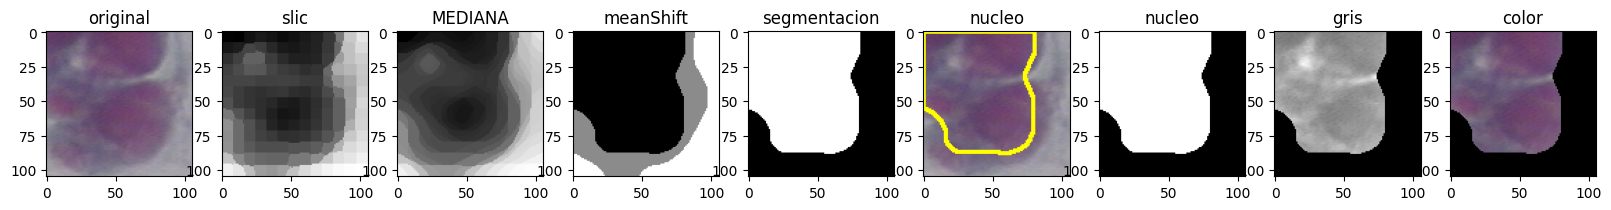

In [10]:
# RUTA DE LA IMAGEN
dirCarpeta = 'DatasetNormalizado/1_normal_superficiel/normalSup31.jpg'
#dirCarpeta = 'DatasetNormalizado/2_normal_intermediate/normalInter13.jpg'
dirCarpeta = 'DatasetNormalizado/3_normal_columnar/normalCol65.jpg'
#dirCarpeta = 'DatasetNormalizado/4_light_dysplastic/anormalMild50.jpg'
#dirCarpeta = 'DatasetNormalizado/5_moderate_dysplastic/anormalMod64.jpg'
#dirCarpeta = 'DatasetNormalizado/6_severe_dysplastic/anormalSevere182.jpg'
#dirCarpeta = 'DatasetNormalizado/7_carcinoma_in_situ/anormalCIS68.jpg'

# PREPROCESAMIENTO
# BGR
imagen = cv2.imread(dirCarpeta)
#RGB
imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
#GRIS
gris   = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY)
img = imagen[:,:,1]


#aplicar superpixeles------------------------------
slic = 1
if slic == 1:
    img = imagen.copy()
    #img = cv2.GaussianBlur(img,(21,21),cv2.BORDER_DEFAULT)
    img = cv2.medianBlur(img,21)
    img = superSlic(img)
    titleSlic = 'slic'
else:
    img = img.copy()
    titleSlic = 'sin Slic'

# #Porcentaje en el que se redimensiona la imagen
# porcentaje = 100
# #calcular el 50 por ciento de las dimensiones originales
# ancho = int(img.shape[1] * porcentaje / 100)
# alto = int(img.shape[0] * porcentaje / 100)
# img = cv2.resize(img, dsize=(ancho,alto))

# filtrado------------------------------------------
opcion = 1
if opcion == 1:
    mediana  = cv2.medianBlur(img,17)
    filtro = mediana
    tituloFiltro = 'MEDIANA'

if opcion == 2:
    bilateral = cv2.bilateralFilter(img,0,40,25)
    filtro = bilateral
    tituloFiltro = 'BILATERAL'

if opcion == 3:
    media = cv2.blur(img,(17,17))
    filtro = media
    tituloFiltro = 'MEDIA'

if opcion == 4:
    gaussiano = cv2.GaussianBlur(img,(17,17),cv2.BORDER_DEFAULT)
    filtro = gaussiano
    tituloFiltro = 'GAUSSIANO'

if opcion == 0:
    filtro = img
    tituloFiltro = 'SIN FILTRO'


# aplanar la imagen
pixelsValues =filtro.reshape(-1,1)
pixelsValues = np.float32(pixelsValues)


#agrupamiento de agrupamiento--------------------------------

opcionAgrup = 1

if opcionAgrup == 1:
    segmentacionImagen = shift2(pixelsValues,filtro)
    tituloSeg = 'meanShift'

elif opcionAgrup == 2:
    segmentacionImagen = kmean(pixelsValues,6,filtro)
    tituloSeg = 'kmean'
    
else:
    segmentacionImagen = filtro
    tituloSeg = 'sin Agrupamiento'



# nucleos
umbral = np.min(segmentacionImagen)
#umbral = umbral+33
umbral= umbral +10
#thresh = segmentacionImagen < umbral
#umbral = umbral
imagen2 = imagen.copy()

# #Porcentaje en el que se redimensiona la imagen
# porcentaje = 100
# #calcular el 50 por ciento de las dimensiones originales
# ancho = int(imagen2.shape[1] * porcentaje / 100)
# alto = int(imagen2.shape[0] * porcentaje / 100)
# imagen2 = cv2.resize(imagen2, dsize=(ancho,alto))


_,thresh = cv2.threshold(segmentacionImagen,umbral, 255, cv2.THRESH_BINARY_INV)
#operaciones morfológicas
kernel = cv2.getStructuringElement(MORPH_ELLIPSE,ksize=(5,5))
thresh = cv2.erode(thresh, kernel, iterations=1)
thresh = cv2.dilate(thresh,kernel, iterations=1)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contorno,cx,cy = selContorno(contours,thresh)
cv2.drawContours(imagen2, contours, contorno, (255,255,0), 2);

#seleccionador de regiones
area = cv2.contourArea(contours[contorno])
_, label, _,centroids = cv2.connectedComponentsWithStats(thresh)
imagenReg = selRegion(label,area)
#imagenReg = selRegion(thresh)
imagenReg[imagenReg > 200] = 255
imagenReg[imagenReg != 255] = 0

# Imagen en escala grises y color 
imgColor = imagen.copy()
for fila in range (gris.shape[0]):
    for columna in range (gris.shape[1]):
        if imagenReg[fila][columna] == 0:
            gris[fila][columna] = 0
            imgColor[fila][columna] = 0
        else:
            pass

#graficar
plt.figure(figsize=(20,20))

plt.subplot(1,9,1)
plt.imshow(imagen)
plt.title('original')


plt.subplot(1,9,2)
plt.imshow(img,'gray')
plt.title(titleSlic)

plt.subplot(1,9,3)
plt.imshow(filtro,'gray')
plt.title(tituloFiltro)


plt.subplot(1,9,4)
plt.imshow(segmentacionImagen,'gray')
plt.title(tituloSeg)

plt.subplot(1,9,5)
plt.imshow(thresh,'gray')
plt.title('segmentacion')


plt.subplot(1,9,6)
plt.imshow(imagen2,'gray')
plt.title('nucleo')

plt.subplot(1,9,7)
plt.imshow(imagenReg,'gray')
plt.title('nucleo')

plt.subplot(1,9,8)
plt.imshow(gris,'gray')
plt.title('gris')

plt.subplot(1,9,9)
plt.imshow(imgColor,'gray')
plt.title('color')

(-0.5, 278.5, 281.5, -0.5)

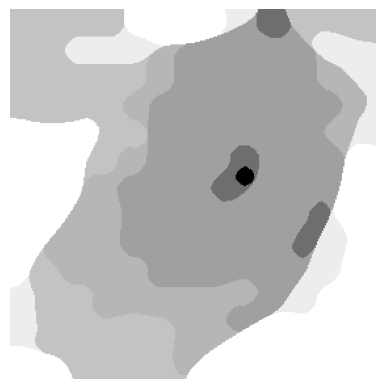

In [47]:
plt.imshow(segmentacionImagen,'gray')
plt.axis(False)

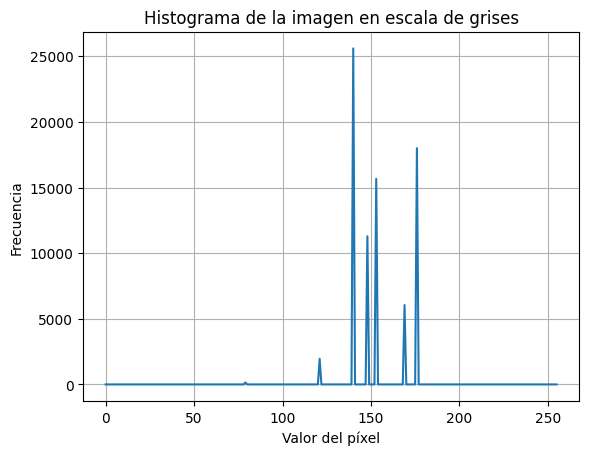

In [50]:
# Calcula el histograma
hist, bins = np.histogram(segmentacionImagen.ravel(), bins=256, range=(0, 256))

# Muestra el histograma
plt.plot(hist)
plt.title('Histograma de la imagen en escala de grises')
plt.xlabel('Valor del píxel')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()



## Preprocesamiento de la imagen de referencia

Se debe preprocesar la imagen de referencia con el fin de poderla compararla con la imagen segmentada

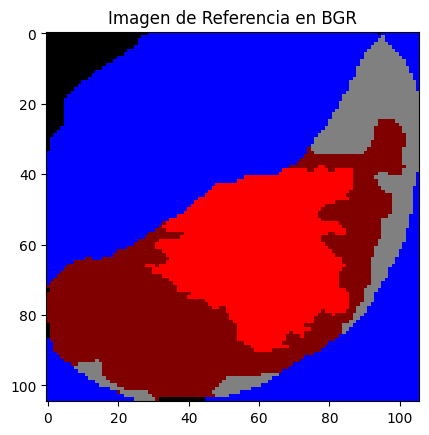

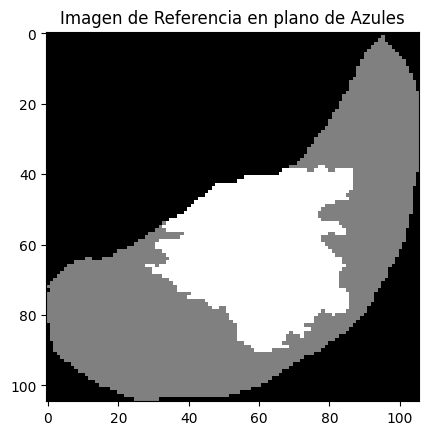

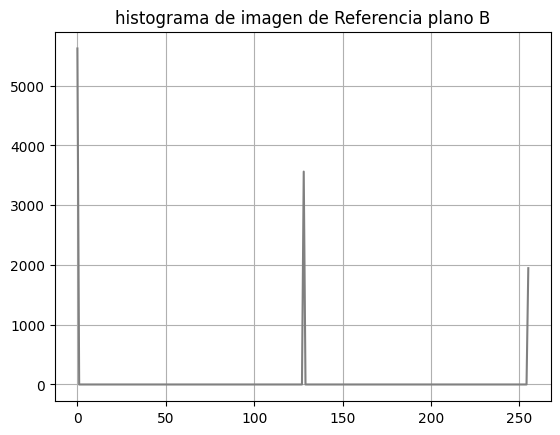

Text(0.5, 1.0, 'Imagen de Referencia Procesada')

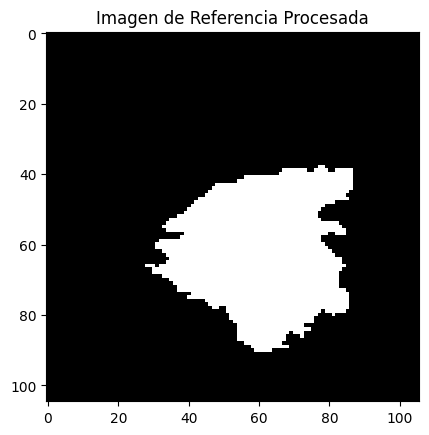

In [70]:
dirCarpetaRef = dirCarpeta[:19]+'REFERENCIA/'+dirCarpeta[19:]
#imagen de referencia en BGR
imagenRef = cv2.imread(dirCarpetaRef)
plt.imshow(imagenRef,'gray')
plt.title('Imagen de Referencia en BGR')
plt.show()
#plano B
plt.imshow(imagenRef[:,:,0],'gray')
plt.title('Imagen de Referencia en plano de Azules')
plt.show()
# histograma plano b
hist = cv2.calcHist([imagenRef],[0],None,[256],[0,256]);
plt.plot(hist,'gray')
plt.grid()
plt.title('histograma de imagen de Referencia plano B')
plt.show()

imagenRef = np.uint8(imagenRef[:,:,0])
imagenRef[imagenRef >= 200] = 255
imagenRef[imagenRef != 255] = 0
plt.imshow(imagenRef,'gray')
plt.title('Imagen de Referencia Procesada')

In [52]:
matrizConfusion (imagenReg,imagenRef)

[184, 0, 149, 78345]

In [71]:
similitud(imagenReg,imagenRef)

[0.2609741431148527, 0.4139246542680019]

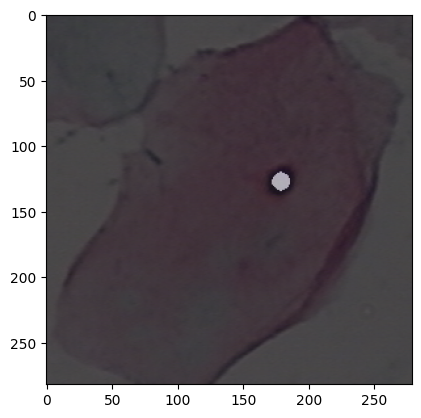

In [67]:
plt.imshow(imagen,'gray')
plt.imshow(imagenReg,cmap='gray',alpha=0.6)

En las imágenes anteriores se puede observar que en el plano de azules, el núcleo corresponde con el color más claro, es decir con intesidades cercanas a 255, el fondo de color negro tiene intensidades de valor cercanas a cero, por tanto, las intesidad entre 100 y 150 corresponden al citoplasma

Por tanto, interesa obtener una imagen solo con el nucleo y el fondo

In [ ]:
#imagen de prueba
plt.imshow(imagenReg,'gray')
plt.title('imagen de Segmentación')
plt.show()

hist = cv2.calcHist([imagenReg],[0],None,[256],[0,256]);
plt.plot(hist,'gray')
plt.grid()
plt.title('histograma imagen Procesada OBTENIDA')

# PREPROCESAMIENTO A MULTIPLES IMÁGENES

El preprocesamiento consiste en los siguientes pasos:<br>
1. Filtrado
2. Generación de Superpíxeles
3. Agrupación por el método de MeanShift
4. Extracción de Nucleo
5. umbralización
6. Detección de bordes
7. Métricas de Segmentación
8. Caracteristicas morfológicas y de textura

In [ ]:
#metricas de evaluacion
clase =[]
celula = []
vPos = []
vNeg = []
fPos = []
fNeg = []
pres = []
reCall = []
exact = []
senRuid = []
medF = []
tasError = []
tasNeg = []
jac = []
dice = []
#características morfológicas
are = []
perimetro = []
circularidad = []
radio = []
eje1 = []
eje2 = []
relacion = []
extension = []
solidez = []
diamEqui = []
excentricidad = []
relacionFeret = []


#características de textura
brillo = []
correlacion = []
contraste = []
disimilitud = []
homogeneidad = []
ASM = []
energia = []
entropia = []

correlacion2 = []
contraste2 = []
disimilitud2 = []
homogeneidad2 = []
ASM2 = []
energia2 = []
entropia2 = []

correlacion3 = []
contraste3 = []
disimilitud3 = []
homogeneidad3 = []
ASM3 = []
energia3 = []
entropia3 = []

#matriz de características
caractNucleo = pd.DataFrame()
#tabla  de metricas de evaluacion
medidasDf = pd.DataFrame()
#archivos de la imagen
dirCarpeta1 = 'DatasetNormalizado/1_normal_superficiel'
dirCarpeta2 = 'DatasetNormalizado/2_normal_intermediate'
dirCarpeta3 = 'DatasetNormalizado/3_normal_columnar'
dirCarpeta4 = 'DatasetNormalizado/4_light_dysplastic'
dirCarpeta5 = 'DatasetNormalizado/5_moderate_dysplastic'
dirCarpeta6 = 'DatasetNormalizado/6_severe_dysplastic'
dirCarpeta7 = 'DatasetNormalizado/7_carcinoma_in_situ'

dirCarpetaImg = [dirCarpeta1, dirCarpeta2, dirCarpeta3, dirCarpeta4, dirCarpeta5,dirCarpeta6,dirCarpeta7]
#dirCarpetaImg = [dirCarpeta1]
for ind, dirCarpeta in enumerate(dirCarpetaImg):
        
    archivos = os.listdir(dirCarpeta)
    archivos = archivos[0:]
    nombreColumna = ['1','2','3','4','5','6','7','8','9']


    fig, ax = plt.subplots(len(archivos),len(nombreColumna))
    fig.set_size_inches(35,300)
    fig.suptitle('SEGMENTACION'+dirCarpeta[18:])

    for i,e in enumerate(archivos):
        #imagen a procesar
        dirImg = dirCarpeta+'/'+e
        #imagen de referencia
        dirImgRef = 'DatasetNormalizado/REFERENCIA/'+dirImg[19:]
        #Lectura de Imágen a procesar
        imagen = cv2.imread(dirImg)
        #Lectura de imagen de referencia
        imagenRef = cv2.imread(dirImgRef)
        
        #IMAGEN A PROCESAR
        #conversion a RGB
        imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
        #GRIS
        gris   = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY)

        img = imagen[:,:,1]
        #clahe = cv2.createCLAHE(clipLimit=5)
        #img = clahe.apply(img) + 10
        #img = cv2.medianBlur(img,11)
        
        

        #aplicar superpixeles---------------------------------------------------
        slic = 1
        if slic == 1:
            img = imagen.copy()
            img = cv2.medianBlur(img,21)
            img = superSlic(img)
            titleSlic = 'slic'
            
        else:
            img = img.copy()
            titleSlic = 'sin slic'

        # FILTRADO-------------------------------------------------------------
        opcion = 1
        if opcion == 1:
            mediana  = cv2.medianBlur(img,17)
            filtro = mediana
            tituloFiltro = 'MEDIANA'
        elif opcion == 2:
            bilateral = cv2.bilateralFilter(img,0,40,25)
            filtro = bilateral
            tituloFiltro = 'BILATERAL'
        elif opcion == 3:
            media = cv2.blur(img,(11,11))
            filtro = media
            tituloFiltro = 'MEDIA'
        elif opcion == 4:
            gaussiano = cv2.GaussianBlur(img,(11,11),cv2.BORDER_DEFAULT)
            filtro = gaussiano
            tituloFiltro = 'GAUSSIANO'
        elif opcion == 0:
            filtro = img
            tituloFiltro = 'SIN FILTRO'

        # aplanar la imagen
        pixelsValues =filtro.reshape(-1,1)
        pixelsValues = np.float32(pixelsValues)


        #CLUSTERING-----------------------------------------------

        opcionAgrup = 1

        if opcionAgrup == 1:
            segmentacionImagen = shift2(pixelsValues,filtro)
            #segmentacionImagen = cv2.threshold(segmentacionImagen,140,255,cv2.THRESH_TOZERO)
            tituloSeg = 'meanShift'

        elif opcionAgrup == 2:
            segmentacionImagen = kmean(pixelsValues,6,filtro)
            tituloSeg = 'kmean'

        elif opcionAgrup == 0:
            segmentacionImagen = filtro
        

        # SEGMENTACION DE NUCLEO---------------------------------------------------------------------
        opcionNucleo = 1
        if opcionNucleo == 1:
            umbral = np.min(segmentacionImagen)
            #umbral = umbral+33
            umbral= umbral +10
            #thresh = segmentacionImagen < umbral
            #umbral = umbral
            ret, thresh = cv2.threshold(segmentacionImagen,umbral, 255, cv2.THRESH_BINARY_INV)
            #operaciones morfológicas
            kernel = cv2.getStructuringElement(MORPH_ELLIPSE,ksize=(5,5))
            thresh = cv2.erode(thresh, kernel, iterations=1)
            thresh = cv2.dilate(thresh,kernel, iterations=1)

        else :
            thresh = segmentacionImagen



        opcionSel = 1
        if opcionSel == 1:
            # selecion de núcleos
            imagen2 = imagen.copy()
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contorno,cx,cy = selContorno(contours,thresh)
            cv2.drawContours(imagen2, contours, contorno, (255,255,0), 2);
        elif opcionSel == 0:
            imagen2 = gris.copy()

        opcionReg = 1
        if opcionReg == 1:
            #seleccionador de regiones
            area = cv2.contourArea(contours[contorno])
            retval, label, stats,centroids = cv2.connectedComponentsWithStats(thresh)
            imagenReg = selRegion(label,area);
        
            imagenReg[imagenReg > 200] = 255
            imagenReg[imagenReg != 255] = 0
            

        #Metricas de evaluacion
        opcionEval = 1
        if opcionEval == 1:
            #tratamiento de imagen de referencia
            imagenRef = np.uint8(imagenRef[:,:,0])
            imagenRef[imagenRef >= 200] = 255
            imagenRef[imagenRef != 255] = 0

            FN,FP,VP,VN = matrizConfusion(imagenReg,imagenRef)
            P,R,E,NSR,FM,ER,NRM = MedidasMC(VP,VN,FP,FN)
            sim = similitud(imagenReg,imagenRef)
            jac.append(sim[0])
            dice.append(sim[1])
            clase.append(dirCarpeta[19:20])
            celula.append(e)
            vPos.append(VP)
            vNeg.append(VN)
            fPos.append(FP)
            fNeg.append(FN)
            pres.append(P)
            reCall.append(R)
            exact.append(E)
            senRuid.append(NSR)
            medF.append(FM)
            tasError.append(ER)
            tasNeg.append(NRM)

        opcionCaract = 1
        if opcionCaract == 1:
            imgColor = imagen.copy()
            for fila in range (gris.shape[0]):
                for columna in range (gris.shape[1]):
                    if imagenReg[fila][columna] == 0:
                        gris[fila][columna] = 0
                        imgColor[fila][columna] = 0
                    else:
                        pass
            #CARACTERISTICAS MORFOLOGICAS
            #area
            ar = cv2.contourArea(contours[contorno])
            #perimetro
            per = cv2.arcLength(contours[contorno],True)
            #circularidad
            cir =  (4*np.pi* ar)/(per**2)
            #radio
            rad = np.sqrt(ar/np.pi)
            #ejes   (eje[1]--->diametro mayor, eje[0]--->diametro menor)
            ejes = get_min_max_feret_from_mask(imagenReg)
            #relacion de aspecto
            x,y,w,h = cv2.boundingRect(contours[contorno])
            aspecto = float(w)/h
            #relacion de aspecto feret
            #ejes = get_min_max_feret_from_mask(imagenReg)
            aspectoFeret = (ejes[1])/(ejes[0])
            #excentricidad, respecto al elipse
            c,l,angle= cv2.fitEllipse(contours[contorno])
            a = max(l) #eje mayor
            b = min(l) #eje menor
            excen = np.sqrt(1+((b*2)/(a*2)))
            #extension
            rect_area = w*h
            exten = float(ar)/rect_area
            # solidez
            hull = cv2.convexHull(contours[contorno])
            hull_area = cv2.contourArea(hull)
            solid = float(ar)/hull_area 

            # diametro equivalente
            equi_diametro = np.sqrt(4*ar/np.pi)          

            #CARACTERISTICAS DE TEXTURA
            # BRILLO
            R,G,B = cv2.split(imgColor)
            # adaptando los datos de cada espectro de color RGB
            Ru = R.reshape(-1,1 )
            Gu = G.reshape(-1,1 )
            Bu = B.reshape(-1,1 )
            # calculando el promedio 
            Ru=np.mean(Ru)
            Gu=np.mean(Gu)
            Bu=np.mean(Bu)
            #coeficientes 
            c=[0.299, 0.587, 0.114]
            # brightness / ecuación
            Y= (c[0]*Ru+c[1]*Gu+c[2]*Bu)

            #GCLM 1
            glcm = graycomatrix(gris,distances=[10],angles=[0],symmetric=True) #1
            corre = graycoprops(glcm,'correlation')
            corre = corre[0][0]
            contr = graycoprops(glcm,'contrast')
            contr = contr[0][0]
            disi = graycoprops(glcm,'dissimilarity')
            disi = disi[0][0]
            homog = graycoprops(glcm,'homogeneity')
            homog = homog[0][0]
            AS = graycoprops(glcm,'ASM')
            AS = AS[0][0]
            ener = graycoprops(glcm,'energy')
            ener = ener[0][0]
            entro =  -np.sum(glcm * np.log2(glcm + (glcm == 0)))
            #GCLM2
            glcm2 = graycomatrix(gris,distances=[20],angles=[45],symmetric=True) #1
            corre2 = graycoprops(glcm2,'correlation')
            corre2 = corre2[0][0]
            contr2 = graycoprops(glcm2,'contrast')
            contr2 = contr2[0][0]
            disi2 = graycoprops(glcm2,'dissimilarity',)
            disi2 = disi2[0][0]
            homog2 = graycoprops(glcm2,'homogeneity')
            homog2 = homog2[0][0]
            AS2 = graycoprops(glcm2,'ASM')
            AS2 = AS2[0][0]
            ener2 = graycoprops(glcm2,'energy')
            ener2 = ener2[0][0]
            entro2 = -np.sum(glcm2 * np.log2(glcm2 + (glcm2 == 0)))
            entro2 = -np.sum(glcm2 * np.log2(glcm2 + (glcm2 == 0)))
            #GCLM3
            glcm3 = graycomatrix(gris,distances=[30],angles=[90],symmetric=True) #1
            corre3 = graycoprops(glcm3,'correlation')
            corre3 = corre3[0][0]
            contr3 = graycoprops(glcm3,'contrast')
            contr3 = contr3[0][0]
            disi3 = graycoprops(glcm3,'dissimilarity')
            disi3 = disi3[0][0]
            homog3 = graycoprops(glcm3,'homogeneity')
            homog3 = homog3[0][0]
            AS3 = graycoprops(glcm3,'ASM')
            AS3 = AS3[0][0]
            ener3 = graycoprops(glcm3,'energy')
            ener3 = ener3[0][0]
            entro3 = -np.sum(glcm3 * np.log2(glcm3 + (glcm3 == 0)))
            #Llenar las listas con sus correspondientes caracteristicas
            #Morfológicas
            are.append(ar)
            perimetro.append(per)
            circularidad.append(cir)
            radio.append(rad)
            eje1.append(ejes[0])
            eje2.append(ejes[1])
            relacion.append(aspecto)
            extension.append(exten)
            solidez.append(solid)
            diamEqui.append(equi_diametro)
            brillo.append(Y)
            excentricidad.append(excen)
            relacionFeret.append(aspectoFeret)
            # textura 1
            correlacion.append(corre)
            contraste.append(contr)
            disimilitud.append(disi)
            homogeneidad.append(homog)
            ASM.append(AS)
            energia.append(ener)
            entropia.append(entro)
            # textura 2
            correlacion2.append(corre2)
            contraste2.append(contr2)
            disimilitud2.append(disi2)
            homogeneidad2.append(homog2)
            ASM2.append(AS2)
            energia2.append(ener2)
            entropia2.append(entro2)
            # textura 3
            correlacion3.append(corre3)
            contraste3.append(contr3)
            disimilitud3.append(disi3)
            homogeneidad3.append(homog3)
            ASM3.append(AS3)
            energia3.append(ener3)
            entropia3.append(entro3)

        # GRAFICAR LAS IMAGENES 
        #nucleo
        imagenTipo = [imagen,img,filtro,segmentacionImagen,thresh,imagen2,imagenReg,gris,imgColor]
        nombreColumna = ['ENTRADA',titleSlic,'FILTRO '+ tituloFiltro,'AGRUPAMIENTO '+tituloSeg,'NUCLEOS','SEGMENTACION','NUCLEO REGION','GRIS','COLOR']


        for j in range(0,len(imagenTipo)):
            ax[i,j].imshow(imagenTipo[j],'gray')
            ax[i,j].set(title=nombreColumna[j]+'-- ('+e+')')
            ax[i,j].axis('off')
plt.subplots_adjust(top=0.97)
plt.show()
#tabla de metricas
medidasDf['CLASE'] = clase
medidasDf['CELULA'] = celula
medidasDf['FN'] = fNeg
medidasDf['FP'] = fPos
medidasDf['VP'] = vPos
medidasDf['VN'] = vNeg
medidasDf['P'] = pres
medidasDf['R'] = reCall
medidasDf['E'] = exact
medidasDf['NSR'] = senRuid
medidasDf['FM'] = medF
medidasDf['ER'] = tasError
medidasDf['NRM'] = tasNeg
medidasDf['JACC'] = jac
medidasDf['DICE'] = dice

#matriz de características
caractNucleo['CLASE'] = clase
caractNucleo['CELULA'] = celula
caractNucleo['AREA'] = are
caractNucleo['PERIMETRO'] = perimetro
caractNucleo['CIRCULARIDAD'] = circularidad
caractNucleo['RADIO'] = radio
caractNucleo['EJE1'] = eje1
caractNucleo['EJE2'] = eje2
caractNucleo['RELACION'] = relacion
caractNucleo['EXTENSION'] = extension
caractNucleo['SOLIDEZ'] = solidez
caractNucleo['DIAMEQUI'] = diamEqui
caractNucleo['BRILLO'] = brillo
caractNucleo['EXCENTRICIDAD'] = excentricidad
caractNucleo['RELACIONFERET'] = aspectoFeret

caractNucleo['CORRELACION'] = correlacion
caractNucleo['CONTRASTE'] = contraste
caractNucleo['DISIMILITUD'] = disimilitud
caractNucleo['HOMOGENEIDAD'] = homogeneidad
caractNucleo['ASM'] = ASM
caractNucleo['ENERGIA'] = energia
caractNucleo['ENTROPIA'] = entropia

caractNucleo['CORRELACION2'] = correlacion2
caractNucleo['CONTRASTE2'] = contraste2
caractNucleo['DISIMILITUD2'] = disimilitud2
caractNucleo['HOMOGENEIDAD2'] = homogeneidad2
caractNucleo['ASM2'] = ASM2
caractNucleo['ENERGIA2'] = energia2
caractNucleo['ENTROPIA2'] = entropia2

caractNucleo['CORRELACION3'] = correlacion3
caractNucleo['CONTRASTE3'] = contraste3
caractNucleo['DISIMILITUD3'] = disimilitud3
caractNucleo['HOMOGENEIDAD3'] = homogeneidad3
caractNucleo['ASM3'] = ASM3
caractNucleo['ENERGIA3'] = energia3
caractNucleo['ENTROPIA3'] = entropia3


# exportar las métricas y las características como archivo CSV
medidasDf.to_csv('evalNucleoMeanShift.csv',encoding='utf-8',sep=';')
caractNucleo.to_csv('caractNucleoShift.csv',encoding='utf-8',sep=';')

In [68]:
# exportar las métricas y las características como archivo CSV
medidasDf.to_csv('evalNucleoMeanShift.csv',encoding='utf-8',sep=';')
caractNucleo.to_csv('caractNucleoShift.csv',encoding='utf-8',sep=';')